# Robotic planning project by backward chaining with anomalies and circumscription

In this project, a knowledge base was created for a robotic system that moves in an environment divided into rooms, linked by doors.
- Doors can be either unlocked and working, or broken.
- The robot can pass through a Door only if it is **unlocked** and **not broken**.

However, the broken state of ports **is not always known**: it is assumed, by default, that a Door is not broken unless explicitly stated. This type of reasoning is based on **Circumscription**, that is, minimization of a predicate (in this case, "BrokenDoor").

## Project goals
- **Build** an OWL knowledge base with the `Room`, `Door`, `Robot`, `BrokenDoor` classes;
    
- **Rappresentare:**
    - `link(d, s1, s2)`: the Door `d` link two rooms;
    - `unlocked(d)`: the Door is open;
    - `broken(d)`: (only if known) the Door is defective;
    - `location(r, s)`: the robot is located in a Room (named `s` for space);
        
- **Implement** at least **an automatic procedure** based on **backward chaining**, which checks whether the robot can reach a target Room from the current Room, using only doors:
    - unlocked;
    - not explicitly failed;
    - correctly linked;
        
- **Simulate** the reasoning for **Circumscription**, assuming that each Door is not broken **by default** (i.e., only if it is not marked as such);

- **Show** at least **two scenarios**:
    - a case in which the robot succeeds in reaching the destination;
    - a case in which the path is blocked by a Door marked as broken;
        
- **Print** a report indicating the path found (if any), or the reason why the robot cannot reach the destination.
    
The project show the effect of **minimization of the predicate "Door broken "**, and demonstrate that the addition of a single anomaly can **invalidate previously available paths**, thus highlighting the **non-monotonic** character of Circumscription.

---

# Initial import

1.  **Import of `owlready2`**: everything necessary from the `owlready2` library is imported in order to define the classes, properties and instances of our knowledge base.
2.  **Import of `graphviz`**: from the `graphviz` library, the `Digraph` object is imDoorto, which is the basis for creating directed graphs.
3. **Import of `random`**: for generating random worlds and anomalies.

In [18]:
from owlready2 import get_ontology, Thing, ObjectProperty, DataProperty, FunctionalProperty, Ontology, World, default_world
from graphviz import Digraph
import random

ONTO_IRI = "http://www.example.org/robot_planning.owl"

---

## Utility functions

### Reset world

The `reset_owl_world` function is designed to do cleanup, removing all ontologies loaded into the default OWL world. This is useful to ensure that executions are independent and unaffected by previous data.

In [19]:
def reset_owl_world():
    """It destroys all ontologies in the default world to ensure a clean restart."""
    if default_world and len(default_world.ontologies) > 0:
        # Creates a copy of the key list because the dictionary is modified during iteration
        for onto_iri in list(default_world.ontologies.keys()):
            onto_to_destroy = default_world.get_ontology(onto_iri)
            if onto_to_destroy:
                onto_to_destroy.destroy()
        print("Previous OWL world successfully destroyed.")
    else:
        print("No OWL worlds to destroy (first run?).")

# performs cleaning at the beginning to ensure a clean state
reset_owl_world()

Previous OWL world successfully destroyed.


### Graphviz visualization

**`visualize_robot_map`**:
1.  **Graph initialization**: create a `Digraph` object of `graphviz`.
2.  **Add nodes (rooms)**: adds a node for each Room, coloring it according to its role in the path (start, destination, intermediate) or the location of the robot.
3.  **Add arcs (doors)**: iterates over all doors and draws an arc between the rooms it links. The style of the arc (color, hatching) indicates the status of the Door (working, blocked, broken).

**`svisualize_found_path`**:
1.  **Orchestration**: call `visualize_robot_map` to generate the base graph.
3.  **Rendering**: saves the graph as a PNG image and displays it.

In [20]:
def visualize_robot_map(ontology, robot=None, onto_path=None):
    """
    Visualize the robot map with rooms, doors, and paths using graphviz
    """
    dot = Digraph(comment='Robot map')
    dot.attr(rankdir='LR')  # Horizontal layout
    dot.attr('node', shape='box', style='filled')
    
    # Add all rooms
    for Room in ontology.Room.instances():
        color = 'lightblue'
        # Highlight onto_path if present
        if onto_path and Room in onto_path:
            if Room == onto_path[0]:
                color = 'lightcoral'  # Start
            elif Room == onto_path[-1]:
                color = 'lightgreen'  # Destination
            else:
                color = 'yellow'  # Intermediate onto_path
        elif robot and robot.location and Room == robot.location:
             color = 'lightgreen'

        dot.node(Room.name, Room.name, fillcolor=color)

    # Add all doors as connections
    for Door in ontology.Door.instances():
        if len(Door.link) >= 2:
            s1, s2 = Door.link[0], Door.link[1]

            # Determine connection style
            color, style, penwidth = 'green', 'solid', '2'
            if not Door.unlocked:
                color, style = 'orange', 'dashed'
            if isinstance(Door, ontology.BrokenDoor):
                color, style, penwidth = 'red', 'dotted', '3'

            # Highlight if part of the onto_path
            if onto_path and any((onto_path[i] == s1 and onto_path[i+1] == s2) or (onto_path[i] == s2 and onto_path[i+1] == s1) for i in range(len(onto_path)-1)):
                penwidth, color = '4', 'blue'
            
            dot.edge(s1.name, s2.name, label=Door.name, color=color, style=style, penwidth=penwidth, dir='none')
    
    return dot

def visualize_found_path(onto, robot, destination, percorso_trovato=None):
    """Displays the search result of onto_path."""
    print(f"\nTarget: from '{robot.location.name}' to '{destination.name}'")

    dot = visualize_robot_map(onto, robot, percorso_trovato)

    filename = f'robot_map_{robot.name}'
    dot.render(filename, format='png', cleanup=True)
    print(f"Map saved as {filename}.png")
    return dot

## Robot ontology creation and visualization

In [21]:
def view_schema_ontology(ontology):
    """
    Create a minimalist visualization of the ontology schema using graphviz.
    It shows the classes, inheritance relationships, and properties.
    """
    dot = Digraph('Ontology scheme')
    dot.attr(rankdir='TB', splines='ortho') # Layout from top to bottom with straight lines
    
    # Styles for nodes
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
    
    # Add all classes as nodes
    class_nodes = set()
    for cls in ontology.classes():
        # We gonna exclude the base classes of OWL to keep the visualization clean
        if cls.name not in ["Thing", "Nothing"]:
            dot.node(cls.name, label=f"<{cls.name}>", shape='record')
            class_nodes.add(cls.name)

    # Add inheritance relationships (is_a)
    for cls in ontology.classes():
        for super_cls in cls.is_a:
            # Let us make sure that the superclass is a defined class and not Thing
            if hasattr(super_cls, 'name') and super_cls.name in class_nodes:
                # The 'empty' arrow is the UML standard for inheritance
                dot.edge(cls.name, super_cls.name, arrowhead='empty', color='black', style='solid')

    # Add properties (Object and Data)
    all_properties = list(ontology.object_properties()) + list(ontology.data_properties())
    for prop in all_properties:
        # Property label with features (e.g., Functional)
        prop_label = f"{prop.name}"
        if isinstance(prop, FunctionalProperty):
            prop_label += " (F)"
            
        prop_color = 'darkgreen' if isinstance(prop, ObjectProperty) else 'darkblue'

        # Link domain to range via property
        if not prop.domain or not prop.range:
            continue

        domain_cls = prop.domain[0]
        range_cls_or_type = prop.range[0]

        # We check that the domain is one of our classes
        if domain_cls.name not in class_nodes:
            continue

        # Handle both range classes (ObjectProperty) and data types (DataProperty)
        if hasattr(range_cls_or_type, 'name'):
            range_name = range_cls_or_type.name
            if range_name not in class_nodes:
                 # It is a data type (e.g., bool, int), create a dedicated node
                dot.node(range_name, label=f"xsd:{range_name}", shape='ellipse', fillcolor='lightgrey')
        else:
            # Fallback for types like <class 'bool'>
            range_name = range_cls_or_type.__name__
            dot.node(range_name, label=f"xsd:{range_name}", shape='ellipse', fillcolor='lightgrey')

        dot.edge(domain_cls.name, range_name, xlabel=prop_label, color=prop_color, style='dashed', fontcolor=prop_color)
        
    return dot

Ontology created with namespace: http://www.example.org/robot_planning.owl
Schema saved as schema_ontology.png


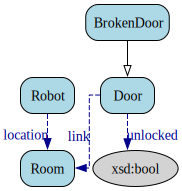

In [22]:
def create_robot_ontology(iri: str) -> Ontology:
    """
    Creates and returns an OWL ontology with the classes and properties
    for planning the robot.
    """
    onto = get_ontology(iri)
    with onto:
        # --- Classes ---
        class Room(Thing): pass
        class Robot(Thing): pass
        class Door(Thing): pass
        class BrokenDoor(Door): pass   # This allows a BrokenDoor to inherit the properties of Door ('link').

        # --- Object Properties ---
        class link(ObjectProperty):
            domain = [Door] # The domain automatically includes subclasses like BrokenDoor
            range = [Room]

        class location(ObjectProperty, FunctionalProperty):
            domain = [Robot]
            range = [Room]

        # --- Data Properties ---
        class unlocked(DataProperty, FunctionalProperty):
            domain = [Door]
            range = [bool]

        # The persistent property 'broken' is represented by the BrokenDoor class.
        # class broken(DataProperty, FunctionalProperty):  
        #     domain = [Door]
        #     range = [bool]

    print(f"Ontology created with namespace: {iri}")
    schema_graph = view_schema_ontology(onto)

    # Save and display the graph
    schema_graph.render('schema_ontology', format='png', cleanup=True)
    print("Schema saved as schema_ontology.png")
    display(schema_graph)
    return onto

# Actual creation of the ontology for static scenarios
onto = create_robot_ontology(ONTO_IRI)

<div class="alert alert-light" role="alert">
    <d><b>⚙ Note on the implementation of <code>BrokenDoor</code></b></d>
    In this version of the project, a more robust and semantically correct approach was taken. Instead of using a boolean property <code>broken</code>, we used a specialized class <code>BrokenDoor</code> which inherit from <code>Door</code>.
    <ul>
        <li><b>Advantage</b>: this model solves the <b>Frame Problem</b> implicitly. In a istance a <code>Door</code> can become a <code>BrokenDoor</code> (<code>.is_a.append(onto.BrokenDoor)</code>), <b>retaining all of its existing properties</b> (<code>link</code>) thanks to inheritance. There is no need to manually restate what has not changed.</li>
        <li><b>Circumscription</b>: the circumscription principle still applies. The default assumption is that an istance belongs only to the class <code>Door</code>. The anomaly (being broken) is additional information that specializes the instance to the class <code>BrokenDoor</code>.</li>
    </ul>
</div>

<div class="alert alert-success" role="alert">
    <d><b>☑ Implemented constituency</b></d>
    The circumscription principle (minimization of the predicate "Door broken") is simulated during map creation: all doors are created as instances of the base class <code>Door</code>. This establishes the default assumption that a Door is not defective, unless it is explicitly specialized as a <code>BrokenDoor</code>.
</div>

## Population of the static map

In this cell, a function, `populate_static_map`, is defined and called to populate the ontology with a fixed, predefined set of rooms, doors, and a robot. This creates the static environment that will be used in the first test scenarios.

☑ Static map successfully populated.
rooms: ['kitchen', 'living_room', 'bedroom1', 'bedroom2', 'office', 'solarium', 'laundry', 'bathroom1', 'bathroom2', 'disengagement']
Doors: ['Door_disengagement_living_room', 'Door_kitchen_living_room', 'Door_living_room_bedroom1', 'Door_living_room_bedroom2', 'Door_bedroom1_bathroom1', 'Door_living_room_office', 'Door_bedroom1_office', 'Door_solarium_laundry', 'Door_solarium_kitchen', 'Door_living_room_solarium', 'Door_living_room_bathroom2']

↔ links created:
  Door_disengagement_living_room: disengagement <-> living_room
  Door_kitchen_living_room: kitchen <-> living_room
  Door_living_room_bedroom1: living_room <-> bedroom1
  Door_living_room_bedroom2: living_room <-> bedroom2
  Door_bedroom1_bathroom1: bedroom1 <-> bathroom1
  Door_living_room_office: living_room <-> office
  Door_bedroom1_office: bedroom1 <-> office
  Door_solarium_laundry: solarium <-> laundry
  Door_solarium_kitchen: solarium <-> kitchen
  Door_living_room_solarium: living_

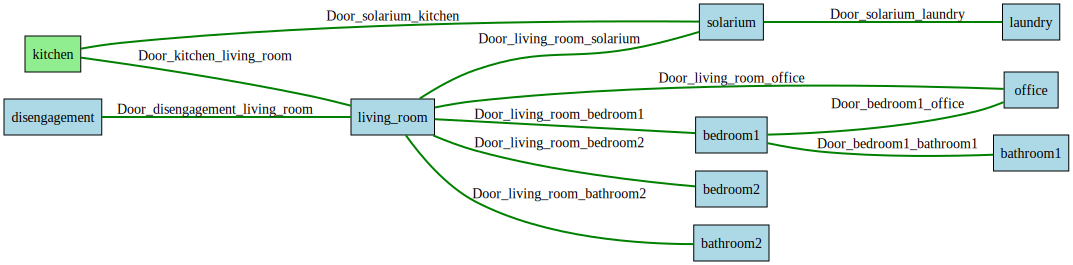

In [23]:
def populate_static_map(onto: Ontology):
    """
    Populate the ontology with instances of rooms, doors, and robots,
    and sets their default properties for the static map.
    """
    with onto:
        # --- Room instances ---
        room_names = ["kitchen", "living_room", "bedroom1", "bedroom2", "office", 
                       "solarium", "laundry", "bathroom1", "bathroom2", "disengagement"]
        rooms = {name: onto.Room(name) for name in room_names}

        # --- Door instances and connections ---
        links = {
            "Door_disengagement_living_room": ("disengagement", "living_room"),
            "Door_kitchen_living_room": ("kitchen", "living_room"),
            "Door_living_room_bedroom1": ("living_room", "bedroom1"),
            "Door_living_room_bedroom2": ("living_room", "bedroom2"),
            "Door_bedroom1_bathroom1": ("bedroom1", "bathroom1"),
            "Door_living_room_office": ("living_room", "office"),
            "Door_bedroom1_office": ("bedroom1", "office"),
            "Door_solarium_laundry": ("solarium", "laundry"),
            "Door_solarium_kitchen": ("solarium", "kitchen"),
            "Door_living_room_solarium": ("living_room", "solarium"),
            "Door_living_room_bathroom2": ("living_room", "bathroom2"),
        }
        
        # Connections between rooms and doors
        for name_Door, (name_s1, name_s2) in links.items():
            Door = onto.Door(name_Door)
            Door.link = [rooms[name_s1], rooms[name_s2]]
            # Setting default properties for doors (ontological world rules)
            Door.unlocked = True
            # modification: we do not set 'broken' as the default property, but create instances of BrokenDoor.
            # Door.broken = False
        
        # --- Robot instance ---
        robot = onto.Robot("robot")   # CHANGE ROBOT ONTOLOGY
        robot.location = rooms["kitchen"]   # CHANGE INITIAL ROBOT LOCATION

    print("☑ Static map successfully populated.")
    print(f"rooms: {[s.name for s in onto.Room.instances()]}")
    print(f"Doors: {[d.name for d in onto.Door.instances()]}")
    print("\n↔ links created:")
    for Door in onto.Door.instances():
        if hasattr(Door, 'link') and len(Door.link) >= 2:
            print(f"  {Door.name}: {Door.link[0].name} <-> {Door.link[1].name}")
    print(f"☃ Robot '{robot.name}' created and positioned in '{robot.location.name}'.")

# Running the function to populate the static ontology
populate_static_map(onto)
display(visualize_robot_map(onto, robot=onto.Robot.instances()[0]))
onto.save(file="robot_planning_map.owl", format="rdfxml")

---

## Scheduling logic of onto_path via Backward Chaining

This cell contains the path finding agorithm of the project. The `dfs_bc` function simulates a **backward chaining** process: to reach a goal (the destination), it tries to satisfy subgoals (find a valid adjacent Room to start from).

1. `current_room` is added to a `set` to avoid loops.
2.  **Basic case**: if the `current_room` is the `destination_room`, the search is successful.
3.  **Recursive step**: the function searches all ports linked to the `current_room` (using `onto.search` for efficiency).
4.  **Condition check**: for each Door, it checks that it is `unlocked`.
5.  **Exploration**: if a Door is valid, the function auto-invokes itself on the Room beyond the Door.
6.  **Construct onto_path**: if the recursive call is successful, the `current_room` is prepended to the returned onto_path, constructing the full path backwards.

In [24]:
def dfs_bc(onto, start_room, current_room, visited_rooms=None):
    """
    DFS backward-chaining: checks whether current_room is reachable from start_room.
    
    Args:
        onto (Ontology): ontology with classes and instances
        start_room (object): Starting room (goal of backward chaining)
        current_room (object): current room
        visited_rooms (set, optional): rooms already visited_rooms to avoid cycles

    Returns:
        list: onto_path from start_room to current_room, or None if not found
    """
    if visited_rooms is None:
        visited_rooms = set()
    visited_rooms.add(current_room)

    # Base case: achieved the goal of backward chaining
    if current_room == start_room:
        return [start_room]

    # Explore ports connected to the current Room
    for Door in list(onto.search(link=current_room)):
        # Check the BrokenDoor class membership (instead of a Boolean property).
        if Door.unlocked and not isinstance(Door, onto.BrokenDoor): # The algorithm assumes that a Door is functional by default with the not isinstance(Door, onto.BrokenDoor) check.
            if len(Door.link) == 2:
                previous_room = next(s for s in Door.link if s != current_room)
                
                if previous_room not in visited_rooms:
                    # Recursion: search onto_path from the start to the previous Room
                    percorso_fino_al_precedente = dfs_bc(onto, start_room, previous_room, visited_rooms)
                    
                    if percorso_fino_al_precedente:
                        # Constructs the onto_path by adding the current Room (search direction)
                        return percorso_fino_al_precedente + [current_room]

    # No onto_path found, backtrack
    return None



<div class="alert alert-success" role="alert">
    <d><b> ☑ Note on the implementation of backward chaining (<code>dfs_bc</code>):</b></d>
    
Backward chaining has been implemented for goal-driven search: Tracing back from the request for verification of a concept to known facts, using the hierarchical structure to infer membership in more general categories.
    <ol>
    <li> We start with a conclusion you want to prove (bc) or a state you want to reach (fc).
    <li> We look for rules, links or states that can Doorre to the goal.
        <ul>
        <li> The previous states become the new subgoals.
        </ul>
    <li>  The process repeats for each subgoal until you reach the initial known facts or starting state.
    </ol>
    
</div>

In [25]:
def dfs_fc(current_room, destination_room, visited_rooms=None):
    """
    Recursive function (DFS, forward-chaining) to find an onto_path.
    Checks whether 'destination_room' is reachable from 'current_room'.
    """
    if visited_rooms is None:
        visited_rooms = set()
    visited_rooms.add(current_room)

    # Base case: the current location is the destination
    if current_room == destination_room:
        return [current_room]

    # Itera through the ports connected to the current Room to find the next valid move
    for Door in list(onto.search(link=current_room)):
        # Rules: the Door must be traversable
        if Door.unlocked and not isinstance(Door, onto.BrokenDoor):
            if len(Door.link) == 2:
                next_room = next(s for s in Door.link if s != current_room)
                
                if next_room not in visited_rooms:
                    # Recursive call: tries to find an onto_path from the new Room
                    next_path = dfs_fc(next_room, destination_room, visited_rooms)
                    if next_path:
                        # If the call is successful, build the complete onto_path (search direction)
                        return [current_room] + next_path

    return None # If no onto_path was found from this Room, return None (backtrack)

<div class="alert alert-light" role="alert">
    <d><b>⚙ Backward chaining <i>vs</i> Forward Chaining :</b></d>
    Both produce the same result, but use different approaches to achieve it:

<ul>
        <li><b>Forward Chaining</b> deduces new information from known facts and applying inference rules, exploiting the hierarchical structure of concepts.</li>
        <li>On the contrary, <b>Backward Chaining</b> starts with the desired outcome and recursively identifies which states or facts must be satisfied to achieve the goal. </li>
    </ul>
    <details>
        <summary><b>Optimization note on the research:</b></summary>
        <ul>
            <li>A computationally onerous implementation might iterate over <code>onto.Door.instances()</code> to each call, checking all ports in the ontology.</li>
            <li>In this notebook we used <code>onto.search(link=current_room)</code>, which leverages owlready2 indexing to efficiently search only relevant ports, i.e., those connected to the current Room.</li>
        </ul>
    </details>
</div>




---

### Report function

This is the "orchestrator" function that combines planning logic with visualization to provide complete output.

**Logic of `plan_and_print_report`**:
1.  **Initialization**: retrieves the target Room instance by its name.
2.  **Search execution**: calls `dfs_bc` to start the search.
3.  **Report Generation**: prints a success message with the onto_path or a failure message with the probable cause (e.g., failed ports).
4.  **Visualize**: call `visualize_found_path` to generate and save an image of the map with the planning result.

In [26]:
def plan_and_print_report(onto: Ontology, robot: Thing, name_destination: str):
    """
    Main function that starts planning and prints a report.
    """
    current_location = robot.location
    destination = onto.search_one(iri=f"*{name_destination}")

    if not destination:
        print(f"☒ The destination room '{name_destination}' does not exist.")
        return

    print(f"\n⚙ Avvio pianificazione per '{robot.name}' da '{current_location.name}' a '{destination.name}'...")
    
    onto_path = dfs_bc(onto, current_location, destination)

    if onto_path:
        path_names = ' -> '.join([s.name for s in onto_path])
        print(f"☑ onto_path found with {len(onto_path)} nodes: {path_names}.")
    else:
        print(f"☒ Unable to find a valid onto_path for '{destination.name}'.")

        known_broken_doors = [d.name for d in onto.BrokenDoor.instances()]
        if known_broken_doors:
            print(f"█ The onto_path is blocked by the following broken doors: {known_broken_doors}")
        else:
            print("▖ Reason: There is no valid onto_path of unlocked and functional doors between the departure and the destination.")

    return visualize_found_path(onto, robot, destination, onto_path)

---

## Scenarios on static map.

This section performs a computer legend and simulation on the static map, showing two separate scenarios to demonstrate nonmonotonic reasoning.

1.  **Scenario 1 (base case)**: we search for an onto_path under normal conditions. The robot should find a path.
2.  **Scenario 2 (with anomaly)**: a Door key on the previous onto_path is marked as `broken`. Planning is performed again: the old onto_path is no longer valid, and the system searches for an alternative one.
3.  **Scenario 3 (with multiple anomalies)**: another broken Door is added, also blocking the alternate onto_path and making the destination unreachable.

Legend saved as robot_map_legend.png


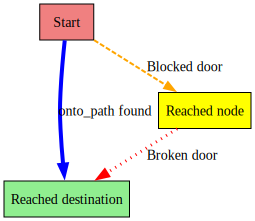

In [27]:
def create_legend():
    """Create a standalone legend to interpret map colors and styles."""
    dot = Digraph(comment='Robot Map Legend')
    dot.attr(rankdir='TB')  # Vertical layout for the legend
    dot.attr('node', shape='box', style='filled')
    
    # Create the legend as the main graph
    dot.node('start_node', 'Start', fillcolor='lightcoral')
    dot.node('end_node', 'Reached destination', fillcolor='lightgreen')
    dot.node('path_node', 'Reached node', fillcolor='yellow')
    dot.edge('start_node', 'end_node', label='onto_path found', color='blue', style='solid', penwidth='4')
    dot.edge('path_node', 'end_node', label='Broken door', color='red', style='dotted', penwidth='3')
    dot.edge('start_node', 'path_node', label='Blocked door', color='orange', style='dashed', penwidth='2')
    
    filename = 'robot_map_legend'
    dot.render(filename, format='png', cleanup=True)
    print(f"Legend saved as {filename}.png")
    return dot

create_legend()


--- SCENARIO 1: normal onto_path with no anomalies ---

⚙ Avvio pianificazione per 'robot' da 'kitchen' a 'bathroom1'...
☑ onto_path found with 4 nodes: kitchen -> living_room -> bedroom1 -> bathroom1.

Target: from 'kitchen' to 'bathroom1'
Map saved as robot_map_robot.png


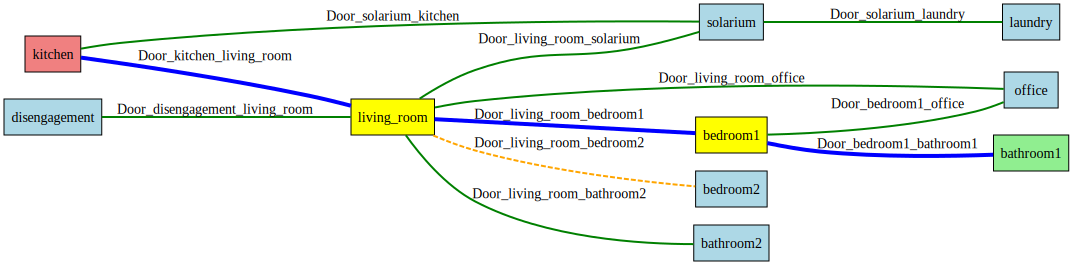

In [28]:
print("\n--- SCENARIO 1: normal onto_path with no anomalies ---")

# Let's make sure all ports are working and unlocked (except one)
with onto:
    for Door in list(onto.Door.instances()):
        Door.unlocked = True
        # If a Door was broken, repair it by removing the BrokenDoor type
        if isinstance(Door, onto.BrokenDoor):
            Door.is_a.remove(onto.BrokenDoor)

    # Block a non-essential Door for the optimal onto_path to make the graph more interesting
    onto.Door_living_room_bedroom2.unlocked = False

    # The robot starts from the kitchen and needs to reach the bathroom1
    robot = onto.robot
    robot.location = onto.kitchen

# Let's run the planning
plan_and_print_report(onto, robot, "bathroom1")


--- SCENARIO 1.1: normal onto_path with no anomalies ---

⚙ Avvio pianificazione per 'robot' da 'kitchen' a 'bathroom1'...
☑ onto_path found with 5 nodes: kitchen -> solarium -> living_room -> bedroom1 -> bathroom1.

Target: from 'kitchen' to 'bathroom1'


Map saved as robot_map_robot.png


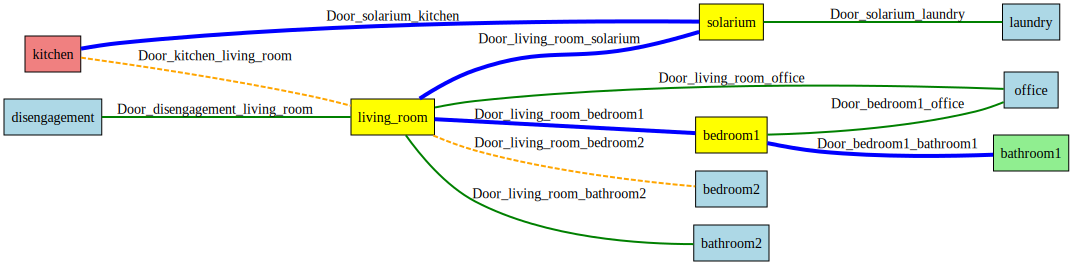

In [29]:
print("\n--- SCENARIO 1.1: normal onto_path with no anomalies ---")

# Let's make sure all ports are working and unlocked (except one)
with onto:
    for Door in list(onto.Door.instances()):
        Door.unlocked = True
        # If a Door was broken, repair it by removing the BrokenDoor type
        if isinstance(Door, onto.BrokenDoor):
            Door.is_a.remove(onto.BrokenDoor)

    # Block a non-essential Door for the optimal onto_path to make the graph more interesting
    onto.Door_living_room_bedroom2.unlocked = False
    onto.Door_kitchen_living_room.unlocked = False

    # The robot starts from the kitchen and needs to reach the bathroom1
    robot = onto.robot
    robot.location = onto.kitchen

# Let's run the planning
plan_and_print_report(onto, robot, "bathroom1")

Per aver potuto utilizzare la classe <code>BrokenDoor</code> la chiamata sarebbe del tipo <code>is_a.append(onto.BrokenDoor)</code>.


--- SCENARIO 1.3: onto_path blocked, search for alternative ---
Anomaly introduced: the Door 'Door_living_room_bedroom1' is now broken.

⚙ Avvio pianificazione per 'robot' da 'kitchen' a 'bathroom1'...
☑ onto_path found with 6 nodes: kitchen -> solarium -> living_room -> office -> bedroom1 -> bathroom1.

Target: from 'kitchen' to 'bathroom1'
Map saved as robot_map_robot.png


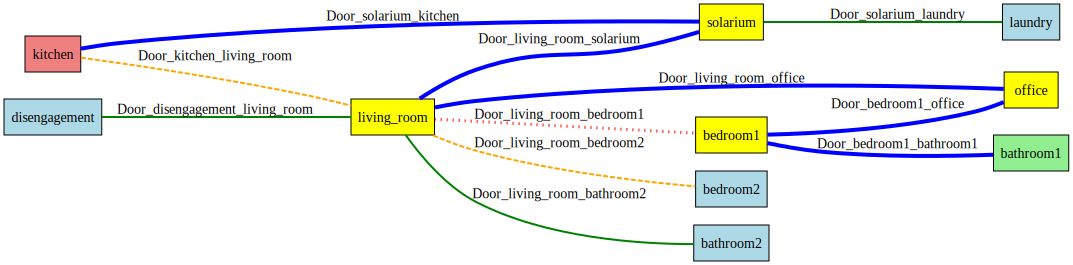

In [30]:
print("\n--- SCENARIO 1.3: onto_path blocked, search for alternative ---")

# Introduciamo un'anomalia: la Door diretta tra living_room e camera da letto si broken.
with onto:
    onto.Door_living_room_bedroom1.is_a.append(onto.BrokenDoor)
    print("Anomaly introduced: the Door 'Door_living_room_bedroom1' is now broken.")

    # The robot tries the same onto_path again
    robot.location = onto.kitchen

# The system should find an alternative onto_path through the office.
plan_and_print_report(onto, robot, "bathroom1")



<div class="alert alert-success" role="alert">
    <d><b>Not monotony and circumscription:</b></d>
        Scenario 1 demonstrates the <i>Non-monotonic nature of the algorithm</i>. A new fact (Door's membership in the class <code>BrokenDoor</code>) is added to the KB. This invalidates the previously correct onto_path of the previous scenario, forcing the robot to find a new conclusion -> a different onto_path.
        In a monotonic system, adding new knowledge can only increase the number of conclusions that can be drawn. In a nonmonotonic system, adding new knowledge can invalidate or retract previous conclusions.
</div>


--- SCENARIO 2: alternate onto_path blocked, destination unreachable ---
Additional anomaly: Door 'Door_bedroom1_office' is now broken.

⚙ Avvio pianificazione per 'robot' da 'kitchen' a 'bathroom1'...
☒ Unable to find a valid onto_path for 'bathroom1'.
█ The onto_path is blocked by the following broken doors: ['Door_living_room_bedroom1', 'Door_bedroom1_office']

Target: from 'kitchen' to 'bathroom1'
Map saved as robot_map_robot.png


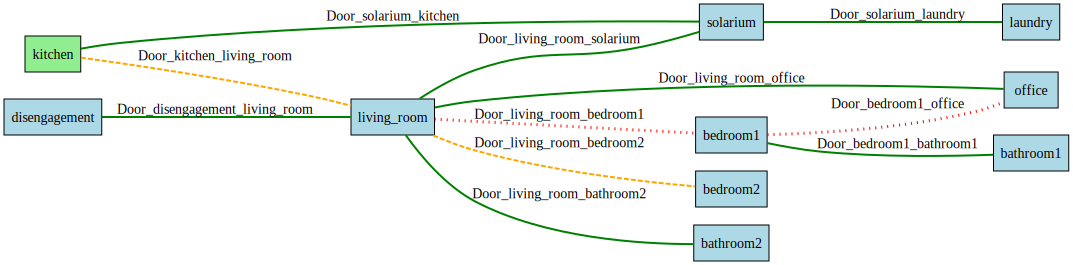

In [31]:
print("\n--- SCENARIO 2: alternate onto_path blocked, destination unreachable ---")

# In addition to the previous Door, we also spoil the one of the alternate onto_path
with onto:
    # The type 'BrokenDoor' is added to the i-Room.
    onto.Door_bedroom1_office.is_a.append(onto.BrokenDoor)
    print("Additional anomaly: Door 'Door_bedroom1_office' is now broken.")

    # The robot tries the same onto_path again.
    robot.location = onto.kitchen

# Now there should be no valid paths.
plan_and_print_report(onto, robot, "bathroom1")

---

## Creating a random world

To make the system more flexible and testable, the `create_random_world` function programmatically generates a map with a configurable number of rooms and ports. The doors randomly link rooms, creating a unique topology each time.

### Function Logic.
1.  **Input validation**: checks that the parameters make sense (e.g., the number of ports should not exceed the maximum possible).
2.  **Cleaning**: removes all pre-existing instances of rooms, doors and robots to ensure a clean environment.
3.  **Room creation**: generates `num_rooms` instances of the `Room` class.
4.  **Creation and interconnection**: enters a loop to create `num_doors` doors. At each step, it chooses two distinct rooms at random and links them, making sure not to create duplicate links.
5.  **Robot creation**: adds an iRoom of `Robot` and places it in a specified starting Room.

In [32]:
def create_random_world(onto: Ontology, num_rooms: int, num_doors: int, robot_name: str = "robot"):
    """
    Populate the ontology with a randomly generated map.

    Args:
        onto: The ontology to be populated.
        num_rooms: The number of rooms to be created.
        num_doors: The number of doors to be created to link rooms.
        robot_name: The name for the robot iRoom.
    """
    if num_rooms < 2:
        print("☒ Error: At least 2 rooms are required to create a world.")
        return
    
    max_possible_doors = num_rooms * (num_rooms - 1) // 2
    if num_doors > max_possible_doors:
        print(f"⚠️ The required number of ports ({num_doors}) is greater than the maximum possible ({max_possible_doors}). There will be created {max_possible_doors} doors.")
        num_doors = max_possible_doors

    with onto:
        # Clear previous instances to avoid overlaps
        for instance in list(onto.Room.instances()) + list(onto.Door.instances()) + list(onto.Robot.instances()):
            instance.destroy()

        # Create rooms
        rooms = [onto.Room(f"Room_{i}") for i in range(num_rooms)]
        print(f"☑ Created {len(rooms)} rooms.")

        # Creates and connects doors
        created_doors = []
        existing_links = set()
        tries, max_tries = 0, num_doors * 5

        while len(created_doors) < num_doors and tries < max_tries:
            tries += 1
            Room1, Room2 = random.sample(rooms, 2)
            connection_key = tuple(sorted((Room1.name, Room2.name)))
            
            if connection_key not in existing_links:
                existing_links.add(connection_key)
                Door = onto.Door(f"Door_{len(created_doors)}")
                Door.link = [Room1, Room2]
                Door.unlocked = True
                # modifica: La proprietà 'broken' è rimossa. Lo stato di default è implicito.
                # Door.broken = False
                created_doors.append(Door)

        print(f"☑ Create {len(created_doors)} doors, linking rooms randomly.")

        # Create and position the robot
        robot = onto.Robot(robot_name)
        if rooms:
            robot.location = rooms[0]
            print(f"☃ Created robot '{robot.name}' and positioned in '{robot.location.name}'.")

    print("\n--- Random World Successfully Generated ---")

### Scenarios on random world.

This final section uses the `create_random_world` function to demonstrate that the entire planning and reporting system works on dynamically generated maps. The purpose is to perform more extensive tests for path finding algorithms.

**Cell Logic**:
1.  **Cleaning and creation**: a completely new and clean ontology (`onto_random`) is created to avoid any interference with the static map.
2.  **Generation**: `create_random_world` is called to populate the ontology with n_stances and n_ports.
3.  **Base test**: a random destination is chosen and the schedule is run. The result is displayed.
4.  **Test with anomaly**: a random Door is marked as `broken`. The schedule is run again to show how the system reacts to the anomaly in the new environment.

In [33]:
def add_random_anomalies(onto: Ontology, num_anomalies: int):
    """Marks a specified number of random doors as faulty."""
    all_doors = list(onto.Door.instances())
    if not all_doors:
        print("Warning: No doors exist to add anomalies to.")
        return

    # Ensure not to sample more doors than exist
    if num_anomalies > len(all_doors):
        print(f"Warning: Requested {num_anomalies} anomalies, but only {len(all_doors)} doors exist. All will be marked as faulty.")
        num_anomalies = len(all_doors)

    doors_to_break = random.sample(all_doors, num_anomalies)
    
    with onto:
        for door in doors_to_break:
            # Add the 'BrokenDoor' type to the door.
            if not isinstance(door, onto.BrokenDoor):
                door.is_a.append(onto.BrokenDoor)   # specialization relation: special slot used to organize generic frames in a hierarchy
            
    print(f"Added {num_anomalies} random anomalies.")

def find_path_and_generate_report(onto: Ontology, robot: Thing, destination_name: str):
    """
    Finds an onto_path, generates a concise report, and returns the onto_path and the graph object.
    """
    current_location = robot.location
    destination = onto.search_one(iri=f"*{destination_name}")

    if not destination:
        report = f"Destination '{destination_name}' not found."
        return None, report, None

    # Find the onto_path using DFS with backward-chaining
    onto_path = dfs_bc(onto, current_location, destination)
    
    # Generate a concise text report
    report = f"Planning from '{current_location.name}' to '{destination.name}':\n"
    if onto_path:
        path_str = ' -> '.join([s.name for s in onto_path])
        report += f"  onto_path found ({len(onto_path)} steps): {path_str}"
    else:
        report += f"  No valid onto_path found."
        
    # Generate the graph object for visualization (does not save to file here)
    graph = visualize_robot_map(ontology=onto, robot=robot, onto_path=onto_path)
    
    return onto_path, report, graph

def run_random_world_scenario(num_rooms, num_doors, num_anomalies):
    """
    Runs a complete and modular test scenario on a randomly generated world.
    1. Creates a random ontology world.
    2. Tries to find an onto_path recursively.
    3. Adds a specified number of random anomalies.
    4. Tries to find an onto_path again and compares the results.
    """
    print(f"--- Running Scenario on Random World ---")
    print(f"Configuration: {num_rooms} rooms, {num_doors} doors, {num_anomalies} anomalies to add.\n")

    # 1. World Setup
    reset_owl_world()
    onto_random = create_robot_ontology(ONTO_IRI + "_random")
    create_random_world(onto_random, num_rooms=num_rooms, num_doors=num_doors, robot_name="random_robot")

    with onto_random:
        robot = onto_random.random_robot
        all_rooms = list(onto_random.Room.instances())
        other_rooms = [s for s in all_rooms if s != robot.location]
        
        if not other_rooms:
            print("Error: there are no other rooms to run a scenario.")
            return

        destination = random.choice(other_rooms)

    # 2. Scenario 1: Base Case (no anomalies)
    print("\n--- Scenario 1: Base onto_path Search ---")
    path1, report1, graph1 = find_path_and_generate_report(onto_random, robot, destination.name)
    print(report1)
    if graph1:
        display(graph1)

    # 3. Introduction of random anomalies
    print(f"\n--- Introducing {num_anomalies} Anomalies ---")
    add_random_anomalies(onto_random, num_anomalies)

    # 4. Scenario 2: With anomalies
    print("\n--- Scenario 2: onto_path Search with Anomalies ---")
    path2, report2, graph2 = find_path_and_generate_report(onto_random, robot, destination.name)
    print(report2)
    if graph2:
        display(graph2)

    # 5. Final Comparison
    print("\n--- Scenario Comparison ---")
    if path1 and not path2:
        print("Result: an onto_path was initially found, but was blocked after adding anomalies.")
    elif not path1 and not path2:
        print("Result: no onto_path found in either scenario. The destination might be unreachable.")
    elif path1 and path2:
        if [s.name for s in path1] != [s.name for s in path2]:
            print("Result: an alternative onto_path was found after adding anomalies.")
        else:
            print("Result: the same onto_path was found; the anomalies did not affect this specific route.")
    elif not path1 and path2:
         print("Result: no onto_path was found initially, but one was found after adding anomalies (this is unexpected).")

---

--- Running Scenario on Random World ---
Configuration: 100 rooms, 200 doors, 70 anomalies to add.

Previous OWL world successfully destroyed.
Ontology created with namespace: http://www.example.org/robot_planning.owl_random
Schema saved as schema_ontology.png


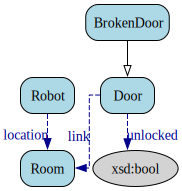

☑ Created 100 rooms.
☑ Create 200 doors, linking rooms randomly.
☃ Created robot 'random_robot' and positioned in 'Room_0'.

--- Random World Successfully Generated ---

--- Scenario 1: Base onto_path Search ---
Planning from 'Room_0' to 'Room_75':
  onto_path found (54 steps): Room_0 -> Room_27 -> Room_22 -> Room_2 -> Room_74 -> Room_73 -> Room_10 -> Room_87 -> Room_95 -> Room_17 -> Room_19 -> Room_91 -> Room_72 -> Room_41 -> Room_57 -> Room_76 -> Room_61 -> Room_68 -> Room_47 -> Room_83 -> Room_8 -> Room_7 -> Room_37 -> Room_14 -> Room_25 -> Room_64 -> Room_34 -> Room_50 -> Room_52 -> Room_98 -> Room_84 -> Room_12 -> Room_53 -> Room_45 -> Room_4 -> Room_80 -> Room_54 -> Room_28 -> Room_13 -> Room_65 -> Room_82 -> Room_63 -> Room_55 -> Room_39 -> Room_79 -> Room_56 -> Room_31 -> Room_77 -> Room_32 -> Room_9 -> Room_35 -> Room_66 -> Room_69 -> Room_75


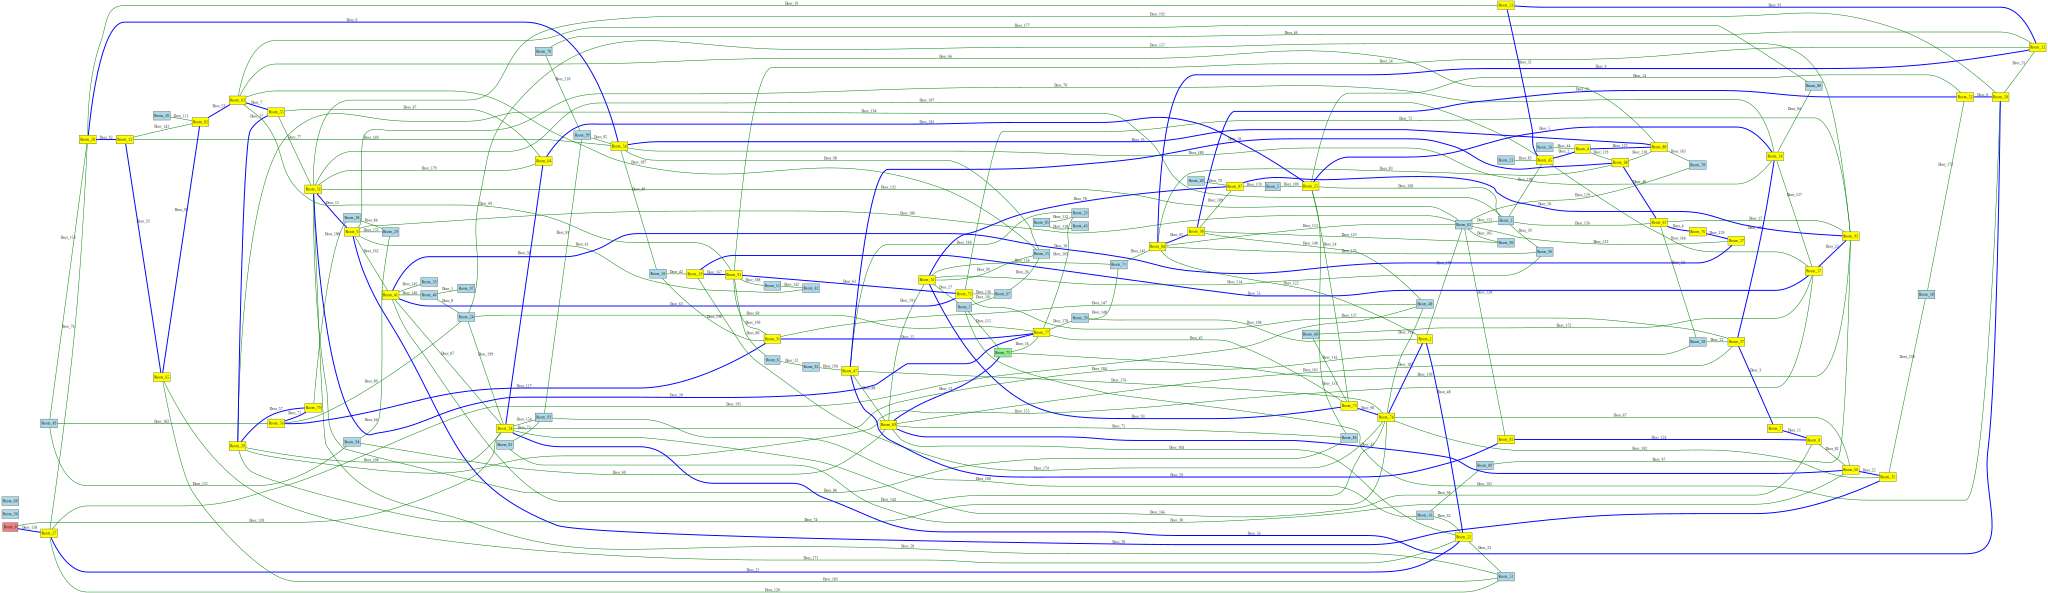


--- Introducing 70 Anomalies ---
Added 70 random anomalies.

--- Scenario 2: onto_path Search with Anomalies ---
Planning from 'Room_0' to 'Room_75':
  onto_path found (32 steps): Room_0 -> Room_34 -> Room_93 -> Room_81 -> Room_66 -> Room_74 -> Room_2 -> Room_59 -> Room_77 -> Room_73 -> Room_25 -> Room_14 -> Room_9 -> Room_32 -> Room_62 -> Room_57 -> Room_41 -> Room_72 -> Room_95 -> Room_87 -> Room_98 -> Room_84 -> Room_12 -> Room_91 -> Room_19 -> Room_36 -> Room_31 -> Room_56 -> Room_49 -> Room_94 -> Room_69 -> Room_75


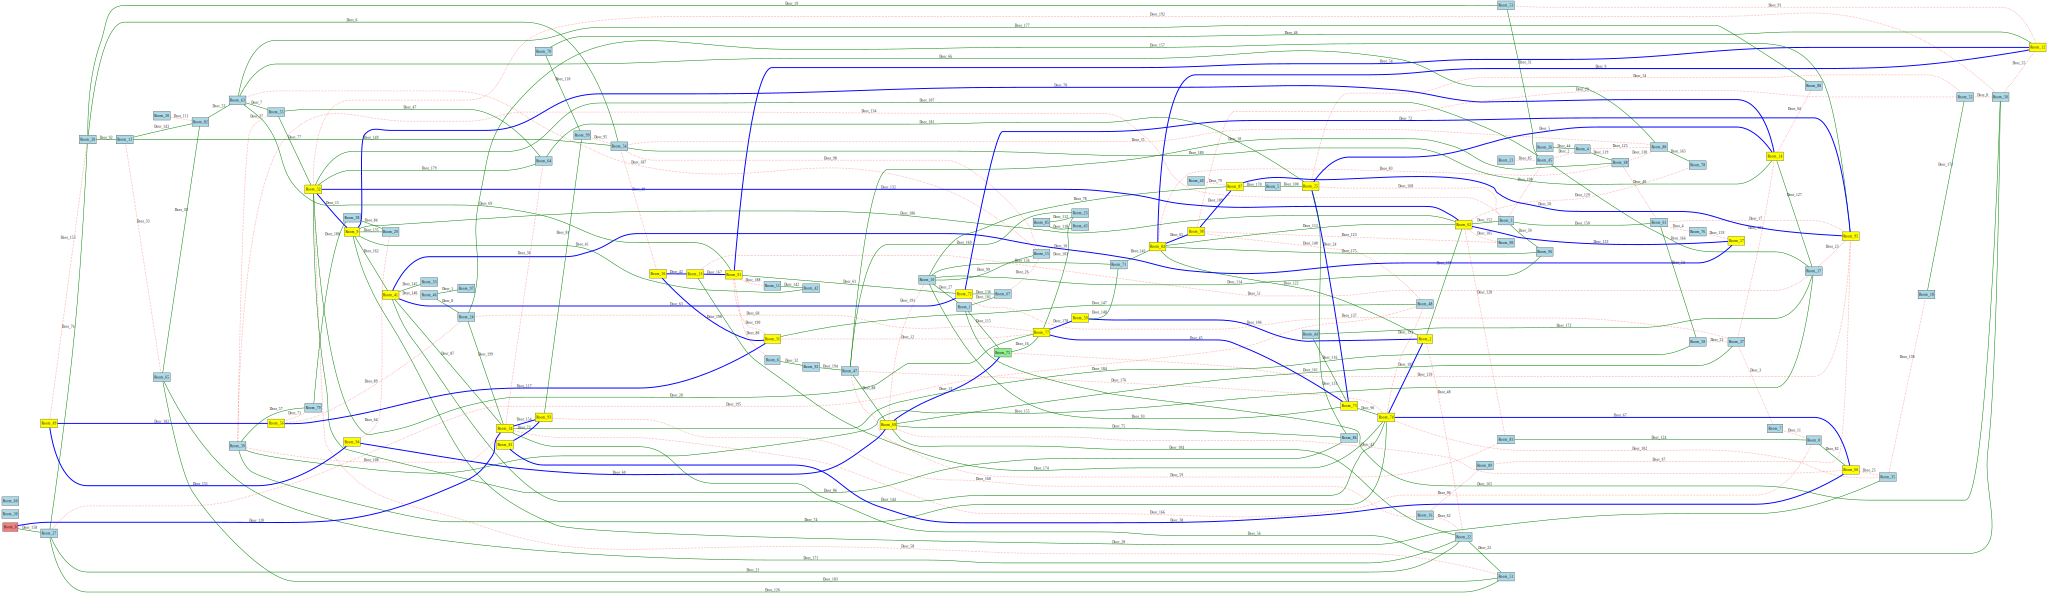


--- Scenario Comparison ---
Result: an alternative onto_path was found after adding anomalies.


In [34]:
run_random_world_scenario(num_rooms=100, num_doors=200, num_anomalies=70)

# Conclusion

An OWL knowledge base for scheduling a robot in an environment with anomalies was developed and successfully tested:
* Implementation of the backward chaining algorithm (`dfs_bc`) allowed finding valid paths.
* Circumscription simulation, through the default assumption that gates are not faulty, was demonstrated.
* Scenarios, on both static map and random world, highlighted the nonmonotonic nature of the system: the addition of new information (a broken Door) correctly invalidated previous conclusions, forcing the system to recalculate an alternative onto_path or determine that the destination was unreachable.